# Sensor Downsampling & Sensitivity Analysis

This notebook evaluates how reducing the number of spectral input bands affects model performance, using subsets of the original hyperspectral data to emulate older ocean color sensors like MODIS and VIIRS. The goal is to assess how much predictive power is retained when fewer spectral bands are used — with and without retraining the model.

## Objectives

1. Define spectral band subsets corresponding to MODIS and VIIRS band centers.
      * MODIS bands (nm): 412, 443, 488, 531, 551, 667, 678, 748(, 869)
      * VIIRS bands (nm): 410, 443, 486, 551, 671, 745(, 862)
      * Note that in contrast to the OCI on PACE, MODIS and VIIRS have dedicated temperature support.

2. Subsample the hyperspectral input features to match these sensor profiles.
3. For each reduced sensor scenario:
   - a. **Retain** the original (full-band) XGBoost hyperparameters and retrain the model.
   - b. **Redo** hyperparameter optimization using Optuna on the reduced input features.
4. Evaluate each model’s predictive performance on the same test set using:
   - Root Mean Squared Error (RMSE)
   - Mean Absolute Error (MAE)
   - R² score
5. Compare feature importance (via SHAP) for full vs. reduced-band models.
6. Summarize tradeoffs between input dimensionality and prediction skill.

<u>**Note that**</u> I will retain the same train/test split as for the hyperspectral effort:

Pros include:
* Controlled comparison $→$ isolates the effect of feature reduction (e.g., using MODIS-like bands) without adding variability from new data splits;
* Direct metric comparison $→$ RMSE, R², MAE values across full-band and reduced-band models are meaningfully comparable;
* Reproducibility $\rightarrow$ Keeps experimental protocol aligned with  main study;
* Avoids redoing test sampling, which might trigger new variability that needs to explaining.

Cons include:
* Not testing generalization under new data splits (but that wasn’t the primary goal).
* Might miss edge-case behaviors in underrepresented regions that randomly landed in the original train or test sets.

> 💡 This analysis informs how well legacy multispectral datasets can support PFG estimation, and highlights the added value of hyperspectral instruments like PACE.


In [51]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import warnings
import joblib

project_path = Path.cwd().parent
sys.path.append(project_path.as_posix())
from loguru import logger

from pipeline.p1_model_trainer import XGBoostTrainer
from scripts.plot_utils import plot_regression, plot_residuals
from scripts.evaluate import model_eval
import matplotlib.pyplot as pp
import matplotlib.style as style

In [46]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [47]:
style.use('bmh')

In [26]:
project_path = Path.cwd().parent
data_path = project_path / 'models'
assert data_path.exists()

In [40]:
dX_train = pd.read_parquet(data_path / 'dX_train.pqt')
dY_train = pd.read_parquet(data_path / 'dY_train.pqt')
dX_test = pd.read_parquet(data_path / 'dX_test.pqt')

### 1. Define spectral band subsets corresponding to MODIS and VIIRS band centers.

##### A. MODIS 
* I will use 8 out the 9 bands reserved for oceanographic applications.
* Bands (nm) taken to be centered around: 412, 443, 488, 531, 551, 667, 678, 748(, 869)

band # | band range
<br>  8  | 405 - 420	
<br>  9	| 438 - 448	
<br>10	| 483 - 493	
<br>11	| 526 - 536	
<br>12	| 546 - 556	
<br>13	| 662 - 672	
<br>14	| 673 - 683	
<br>15	| 743 - 753	
<br>16	| 862 - 877

* See [here](https://modis.gsfc.nasa.gov/about/specifications.php) for more.

<br>$→$ Note that 869 is not among the available bands in the data set.



In [37]:
current_bands = dX_train.filter(regex='[0-9]+', axis='columns').columns.to_numpy().astype('int')
modis_bands = [412, 443, 488, 531, 551, 667, 678, 748]

target_bands = current_bands[[np.abs(current_bands - mb).argmin() for mb in modis_bands]].astype('str')
target_bands


array(['410', '440', '490', '530', '550', '670', '680', '750'],
      dtype='<U21')

In [38]:
dX_modis_train = dX_train[target_bands].copy()

In [39]:
dX_modis_train['temp'] = dX_train.temp
dX_modis_train.head()

,410,440,490,530,550,670,680,750,temp
1844870,0.003188,0.002824,0.003161,0.002318,0.001883,0.000183,0.000169,1.321252e-05,0.665892
149108,0.007589,0.006673,0.004297,0.001707,0.001216,0.000086,0.000077,1.655570e-05,6.310231
675924,0.006431,0.005639,0.003987,0.001786,0.001293,0.000096,0.000089,1.000000e-20,26.572124
216343,0.006812,0.005883,0.004122,0.001904,0.001403,0.000115,0.000103,1.374958e-05,23.469124
556110,0.006078,0.005318,0.003768,0.001731,0.001280,0.000101,0.000092,1.570986e-05,21.516634


In [41]:
dX_modis_test = dX_test[target_bands].copy()
dX_modis_test['temp'] = dX_test.temp

##### B. VIIRS 
* I will use 8 out the 9 bands reserved for oceanographic applications.
* Bands (nm) taken to be centered around: (nm): 410, 445, 490, 555, 673, 746 (, 865)
band # | band (μm) | band width (μ)
<br> M1 | 0.415 | 0.02	
<br> M2	| 0.445	| 0.02
<br> M3	| 0.490	| 0.02
<br> M4	| 0.555	| 0.02
<br> M5	| 0.673	| 0.021
<br> M6	| 0.746	| 0.021

* See [here](https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/viirs/) for more.

<br>$→$ Note that 865 is not among the available bands in the present data set. 

In [42]:
viirs_bands = [410, 445, 490, 555, 673, 746]
target_bands = current_bands[[np.abs(current_bands - vb).argmin() for vb in viirs_bands]].astype('str')
target_bands

array(['410', '440', '490', '550', '670', '750'], dtype='<U21')

In [43]:
dX_viirs_train = dX_train[target_bands].copy()
dX_viirs_train['temp'] = dX_train.temp
dX_viirs_test = dX_test[target_bands].copy()
dX_viirs_test['temp'] = dX_test.temp


In [44]:
dX_viirs_train.to_parquet(data_path / 'dX_viirs_train.pqt')
dX_viirs_test.to_parquet(data_path/'dX_viirs_test.pqt')
dX_modis_train.to_parquet(data_path / 'dX_modist_train.pqt')
dX_modis_test.to_parquet(data_path / 'dX_modis_test.pqt')

### 3. For each reduced sensor scenario:
   ####  A. **Retain** the original (full-band) XGBoost hyperparameters and retrain the model.

In [48]:
# Reloading the optimzied and trained model
optimized_model = joblib.load(project_path / "models/optimized_trained_model.pkl")
logger.info("Model loaded successfully.")

2025-03-31 12:47:12.196 | INFO     | __main__:<module>:3 - Model loaded successfully.


In [77]:
pre_optimized_params = optimized_model.get_params()
clean_params = {k.replace("estimator__", ""): v for k, v in pre_optimized_params.items()}


In [78]:
optimized_model_trainer=XGBoostTrainer(params=clean_params)

In [54]:
modis_optimized_model = optimized_model_trainer.train_model(dX_modis_train, dY_train)

/Users/erdemkarakoylu/miniconda3/envs/ptoa_py312/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:52:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1733179641447/work/src/learner.cc:740: 
Parameters: { "estimator", "estimator__colsample_bytree", "estimator__enable_categorical", "estimator__gamma", "estimator__learning_rate", "estimator__max_depth", "estimator__missing", "estimator__n_estimators", "estimator__objective", "estimator__subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/erdemkarakoylu/miniconda3/envs/ptoa_py312/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:52:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1733179641447/work/src/learner.cc:740: 
Parameters: { "estimator", "estimator__colsample_bytree", "estimator__enable_categorical", "estimator__gamma", "estimator__learning_rate", "estimator__max_depth", "estimator__missing", "estimator__n_estimators", "estimator__objective", "estimator_

In [57]:
dY_test = pd.read_parquet(data_path / 'dY_test.pqt')

In [62]:
dY_modis_pred = modis_optimized_model.predict(dX_modis_test)
dY_modis_pred = pd.DataFrame(dY_modis_pred, columns=dY_test.columns)

In [91]:
eval_scores = model_eval(dY_test, dY_modis_pred)

2025-04-01 18:20:13.548 | INFO     | scripts.evaluate:model_eval:21 - 
Metrics for dia:
2025-04-01 18:20:13.549 | INFO     | scripts.evaluate:model_eval:22 -   MSE: 0.0011
2025-04-01 18:20:13.549 | INFO     | scripts.evaluate:model_eval:23 -   RMSE: 0.0330
2025-04-01 18:20:13.549 | INFO     | scripts.evaluate:model_eval:24 -   MAE: 0.0170
2025-04-01 18:20:13.550 | INFO     | scripts.evaluate:model_eval:25 -   R-squared: 0.9325
2025-04-01 18:20:13.550 | INFO     | scripts.evaluate:model_eval:26 -   MAE/StDev_true 0.133
2025-04-01 18:20:13.555 | INFO     | scripts.evaluate:model_eval:21 - 
Metrics for chl:
2025-04-01 18:20:13.555 | INFO     | scripts.evaluate:model_eval:22 -   MSE: 0.0003
2025-04-01 18:20:13.556 | INFO     | scripts.evaluate:model_eval:23 -   RMSE: 0.0160
2025-04-01 18:20:13.557 | INFO     | scripts.evaluate:model_eval:24 -   MAE: 0.0073
2025-04-01 18:20:13.557 | INFO     | scripts.evaluate:model_eval:25 -   R-squared: 0.8930
2025-04-01 18:20:13.558 | INFO     | scripts.

In [92]:
df_scores = pd.DataFrame(eval_scores)
df_scores.to_parquet('./tabled_results/df_post_hpo_eval_scores_test_set_MODIS.pqt')

In [93]:
dY_test.shape

(252322, 7)

In [94]:
dY_modis_pred.shape

(252322, 7)

In [95]:
def plot_all_residuals(dY_test, dY_pred):
    f, axs = pp.subplots(nrows=3, ncols=3, figsize=(8, 8))
    for ax, col in zip(axs.ravel(), dY_test.columns):
        try:
            plot_residuals(dY_test[col].values, dY_pred[col].values, ax, col)
        except:
            logger.error(f"problem with {col}")
    axs.ravel()[-2].set_visible(False)
    axs.ravel()[-1].set_visible(False)
    f.tight_layout()
    return f, axs

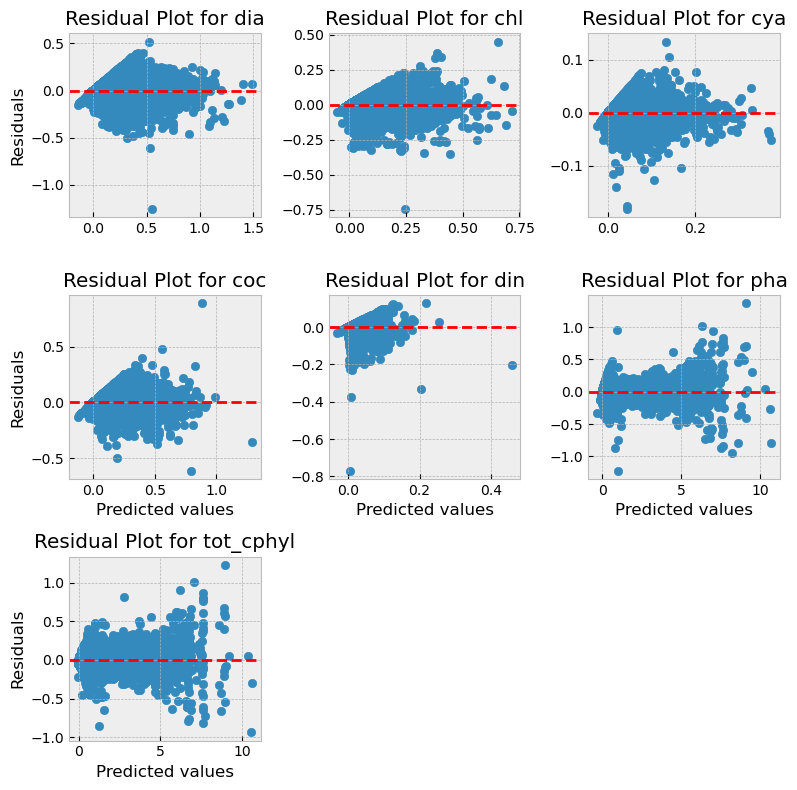

In [96]:
f_modis, axs_modis = plot_all_residuals(dY_test, dY_modis_pred)

In [97]:
figures_path = project_path/'notebooks/figures/optimized_model_plots'
assert figures_path.exists()

In [98]:
f_modis.savefig(figures_path/'modis_residuals.png', bbox_inches='tight', dpi=300)

In [72]:
def plot_all_regressions(dY_test, dY_pred, sensor):
    f_fit, axs = pp.subplots(nrows=3, ncols=3, figsize=(8, 7))
    columns = ['Diatom', 'Chlorophyte', 'Cyanobacteria', 'Coccolithophore', 'Dinoflagellate', 'Phaeocystis', 'Total Chl.a']
    for col, ax, lbl in zip(dY_test.columns, axs.ravel(), columns):
        r2 = eval_scores[col]['r2']
        mae2truestd = eval_scores[col]['mae_2_true_std_ratio']
        string = r'$R^2:$ ' + f'{r2:.2f}\n' + r'$MAE/STD_{true}:$ ' + f'{mae2truestd:.2f}'
        plot_regression(dY_test[col], dY_pred[col], col, ax=ax, leg=string)
        ax.set(title=lbl, ylabel='predicted')
    for ax in axs.ravel()[-2:]:
        ax.set_visible(False)
    f_fit.tight_layout()
    f_fit.savefig(figures_path / f'goodness-of-fit_{sensor}.png', bbox_inches='tight', dpi=300)
    return f_fit, axs

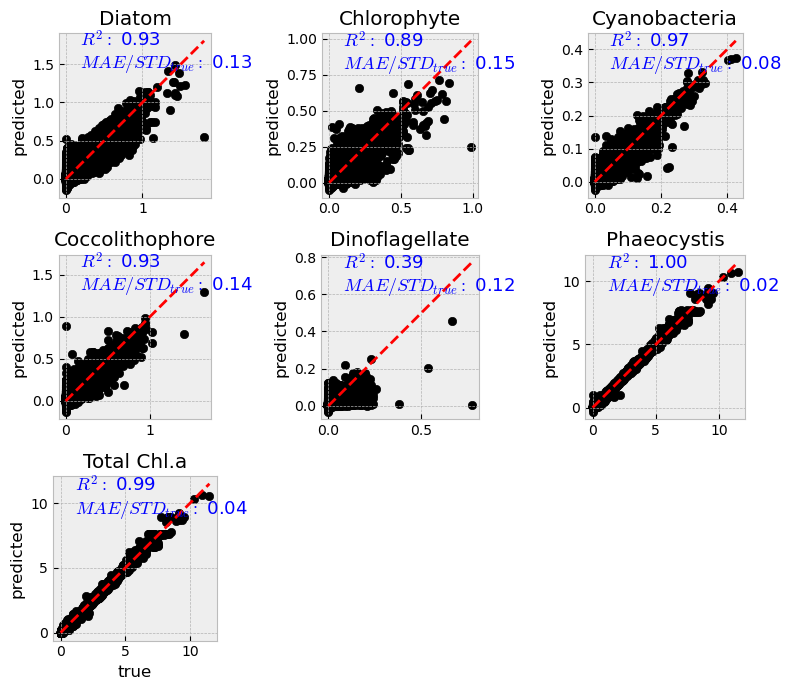

In [74]:
f_fit, axs = plot_all_regressions(dY_test, dY_pred=dY_modis_pred, sensor='MODIS')

In [99]:
formatted_df = df_scores.map(lambda x: "{:.2e}".format(x))
formatted_df.rename(
    columns=dict(
        dia='diatom', chl='chloroph', cya='cyanobac', coc='coccolit', din='dinoflag', pha='phaeo', tot_cphyl='tot chl a'
        ), 
    index=dict(
        mse='Mean Squared Error', rmse='Root MSE', mae='Mean Abs. Error', r2='R squared', mae_2_true_std_ratio = 'MAE : Std. Dev of True'
        ),
    inplace=True
    )

formatted_df

,diatom,chloroph,cyanobac,coccolit,dinoflag,phaeo,tot chl a
Mean Squared Error,1.09e-03,2.56e-04,2.04e-05,3.89e-04,2.56e-05,6.63e-04,8.70e-04
Root MSE,3.30e-02,1.60e-02,4.51e-03,1.97e-02,5.06e-03,2.57e-02,2.95e-02
Mean Abs. Error,1.70e-02,7.34e-03,2.17e-03,1.04e-02,8.08e-04,8.59e-03,1.65e-02
R squared,9.32e-01,8.93e-01,9.69e-01,9.30e-01,3.87e-01,9.96e-01,9.95e-01
MAE : Std. Dev of True,1.33e-01,1.50e-01,8.40e-02,1.40e-01,1.25e-01,2.07e-02,4.12e-02


In [79]:
viirs_optimized_model = optimized_model_trainer.train_model(dX_viirs_train, dY_train)

/Users/erdemkarakoylu/miniconda3/envs/ptoa_py312/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:10:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1733179641447/work/src/learner.cc:740: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/erdemkarakoylu/miniconda3/envs/ptoa_py312/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:10:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1733179641447/work/src/learner.cc:740: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/erdemkarakoylu/miniconda3/envs/ptoa_py312/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:10:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1733179641447/work/src/learner.cc:740: 
Parameters: { "estimator" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/erdemkarakoylu/miniconda3/envs/ptoa_py312/lib/python3.12/site-packages/xgboost/core.py:158: User

In [80]:
dY_viirs_pred = viirs_optimized_model.predict(dX_viirs_test)
dY_viirs_pred = pd.DataFrame(dY_viirs_pred, columns=dY_test.columns)

In [81]:
eval_scores_viirs = model_eval(dY_test, dY_viirs_pred)

2025-03-31 13:12:17.931 | INFO     | scripts.evaluate:model_eval:21 - 
Metrics for dia:
2025-03-31 13:12:17.932 | INFO     | scripts.evaluate:model_eval:22 -   MSE: 0.0007
2025-03-31 13:12:17.932 | INFO     | scripts.evaluate:model_eval:23 -   RMSE: 0.0269
2025-03-31 13:12:17.932 | INFO     | scripts.evaluate:model_eval:24 -   MAE: 0.0127
2025-03-31 13:12:17.933 | INFO     | scripts.evaluate:model_eval:25 -   R-squared: 0.9552
2025-03-31 13:12:17.933 | INFO     | scripts.evaluate:model_eval:26 -   MAE/StDev_true 0.100
2025-03-31 13:12:17.939 | INFO     | scripts.evaluate:model_eval:21 - 
Metrics for chl:
2025-03-31 13:12:17.940 | INFO     | scripts.evaluate:model_eval:22 -   MSE: 0.0002
2025-03-31 13:12:17.940 | INFO     | scripts.evaluate:model_eval:23 -   RMSE: 0.0125
2025-03-31 13:12:17.940 | INFO     | scripts.evaluate:model_eval:24 -   MAE: 0.0053
2025-03-31 13:12:17.941 | INFO     | scripts.evaluate:model_eval:25 -   R-squared: 0.9349
2025-03-31 13:12:17.941 | INFO     | scripts.

In [82]:
df_scores_viirs = pd.DataFrame(eval_scores_viirs)
df_scores_viirs.to_parquet('./tabled_results/df_post_hpo_eval_scores_test_set_VIIRS.pqt')

In [88]:
df_scores_viirs

,dia,chl,cya,coc,din,pha,tot_cphyl
mse,0.000724,0.000156,0.000011,0.000212,0.000021,0.001146,0.001261
rmse,0.026908,0.012495,0.003383,0.014546,0.004617,0.033851,0.035506
mae,0.012680,0.005317,0.001446,0.007033,0.000688,0.006045,0.011082
r2,0.955163,0.934870,0.982810,0.962079,0.489246,0.993364,0.992146
mae_2_true_std_ratio,0.099780,0.108600,0.056049,0.094158,0.106454,0.014547,0.027661


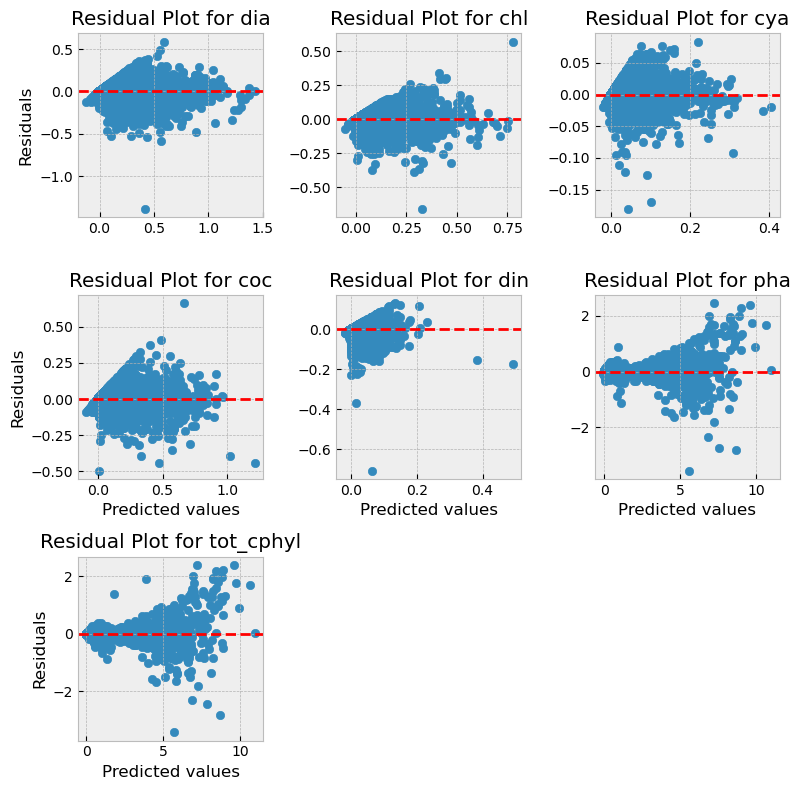

In [84]:
f_viirs, axs_viirs = plot_all_residuals(dY_test, dY_viirs_pred)

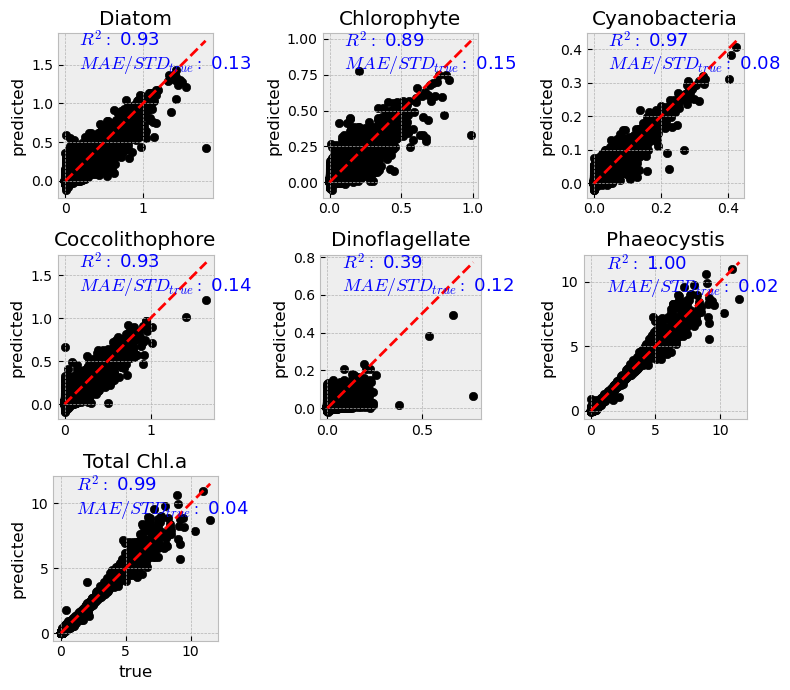

In [85]:
f_fit_viirs, viirs_axs = plot_all_regressions(
    dY_test, dY_pred=dY_viirs_pred, sensor='VIIRS')

In [90]:
formatted_df_viirs = df_scores_viirs.map(lambda x: "{:.2e}".format(x))
formatted_df_viirs.rename(
    columns=dict(
        dia='diatom', chl='chloroph', cya='cyanobac', coc='coccolit', din='dinoflag', pha='phaeo', tot_cphyl='tot chl a'
        ), 
    index=dict(
        mse='Mean Squared Error', rmse='Root MSE', mae='Mean Abs. Error', r2='R squared', mae_2_true_std_ratio = 'MAE : Std. Dev of True'
        ),
    inplace=True
    )

formatted_df_viirs

,diatom,chloroph,cyanobac,coccolit,dinoflag,phaeo,tot chl a
Mean Squared Error,7.24e-04,1.56e-04,1.14e-05,2.12e-04,2.13e-05,1.15e-03,1.26e-03
Root MSE,2.69e-02,1.25e-02,3.38e-03,1.45e-02,4.62e-03,3.39e-02,3.55e-02
Mean Abs. Error,1.27e-02,5.32e-03,1.45e-03,7.03e-03,6.88e-04,6.05e-03,1.11e-02
R squared,9.55e-01,9.35e-01,9.83e-01,9.62e-01,4.89e-01,9.93e-01,9.92e-01
MAE : Std. Dev of True,9.98e-02,1.09e-01,5.60e-02,9.42e-02,1.06e-01,1.45e-02,2.77e-02


In [101]:
df_scores_full= pd.read_parquet('./tabled_results/df_post_hpo_eval_scores_test_set_.pqt')


In [105]:
df_scores

,dia,chl,cya,coc,din,pha,tot_cphyl
mse,0.001091,0.000256,0.000020,0.000389,0.000026,0.000663,0.000870
rmse,0.033025,0.016014,0.004515,0.019712,0.005058,0.025747,0.029491
mae,0.016964,0.007338,0.002168,0.010424,0.000808,0.008588,0.016501
r2,0.932463,0.893008,0.969385,0.930358,0.387118,0.996161,0.994581
mae_2_true_std_ratio,0.133491,0.149873,0.084029,0.139544,0.124999,0.020667,0.041189


In [104]:
df_scores_full

,dia,chl,cya,coc,din,pha,tot_cphyl
mse,0.000340,0.000100,0.000003,0.000086,0.000020,0.000110,0.000193
rmse,0.018436,0.010004,0.001701,0.009269,0.004430,0.010486,0.013908
mae,0.008776,0.004203,0.000780,0.004204,0.000637,0.003132,0.007277
r2,0.978953,0.958245,0.995653,0.984602,0.529777,0.999363,0.998795
mae_2_true_std_ratio,0.069062,0.085844,0.030209,0.056285,0.098557,0.007537,0.018164


In [106]:
df_scores_viirs

,dia,chl,cya,coc,din,pha,tot_cphyl
mse,0.000724,0.000156,0.000011,0.000212,0.000021,0.001146,0.001261
rmse,0.026908,0.012495,0.003383,0.014546,0.004617,0.033851,0.035506
mae,0.012680,0.005317,0.001446,0.007033,0.000688,0.006045,0.011082
r2,0.955163,0.934870,0.982810,0.962079,0.489246,0.993364,0.992146
mae_2_true_std_ratio,0.099780,0.108600,0.056049,0.094158,0.106454,0.014547,0.027661


In [109]:
rmse_full = df_scores_full.loc['rmse'].tolist()
rmse_modis = df_scores.loc['rmse'].tolist()
rmse_viirs = df_scores_viirs.loc['rmse'].tolist()

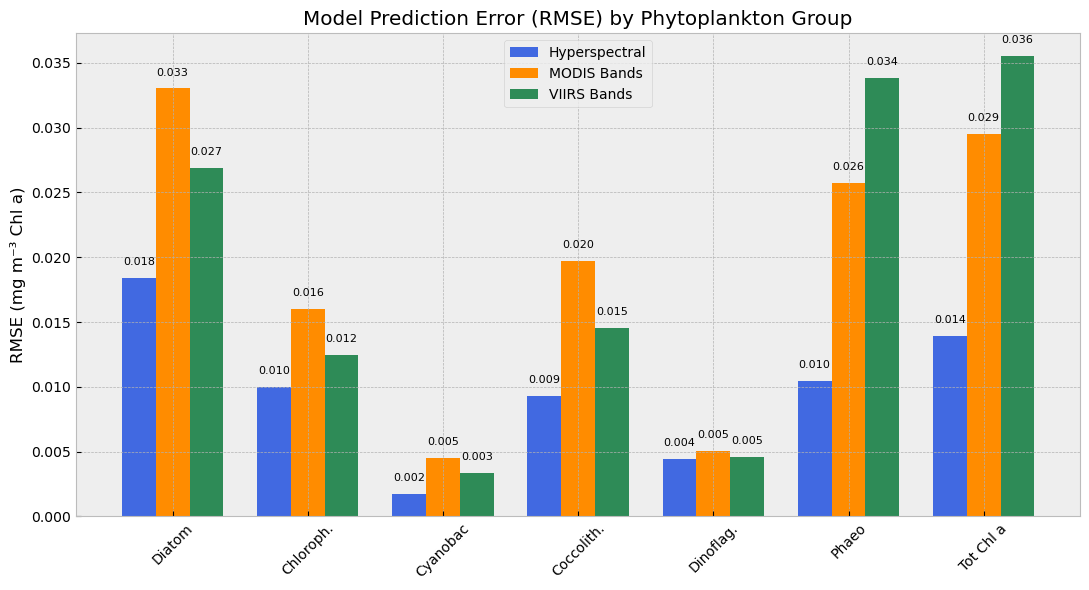

In [110]:
labels = ['Diatom', 'Chloroph.', 'Cyanobac', 'Coccolith.', 'Dinoflag.', 'Phaeo', 'Tot Chl a']

# RMSE values for each model
#rmse_full =  [0.0184, 0.0100, 0.0017, 0.00927, 0.00443, 0.0105, 0.0139]
#rmse_modis = [0.0330, 0.0160, 0.00451, 0.0197, 0.00506, 0.0257, 0.0295]
#rmse_viirs = [0.0269, 0.0125, 0.00338, 0.0145, 0.00462, 0.0339, 0.0355]

# Bar positions
x = np.arange(len(labels))
width = 0.25

# Plot setup
fig, ax = pp.subplots(figsize=(11, 6))

# Bars
ax.bar(x - width, rmse_full, width, label='Hyperspectral', color='royalblue')
ax.bar(x, rmse_modis, width, label='MODIS Bands', color='darkorange')
ax.bar(x + width, rmse_viirs, width, label='VIIRS Bands', color='seagreen')

# Labels, title, ticks
ax.set_ylabel('RMSE (mg m⁻³ Chl a)')
ax.set_title('Model Prediction Error (RMSE) by Phytoplankton Group')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

# Annotate bars
for i in range(len(labels)):
    ax.text(x[i] - width, rmse_full[i] + 0.001, f"{rmse_full[i]:.3f}", ha='center', fontsize=8)
    ax.text(x[i], rmse_modis[i] + 0.001, f"{rmse_modis[i]:.3f}", ha='center', fontsize=8)
    ax.text(x[i] + width, rmse_viirs[i] + 0.001, f"{rmse_viirs[i]:.3f}", ha='center', fontsize=8)

# Formatting
ax.yaxis.grid(True)
fig.tight_layout()
fig.savefig("pfg_rmse_comparison_full_modis_viirs.png", dpi=300)



### Sensitivity Analysis - Shapley Values

In [ ]:
from scripts.evaluate import plot_shap, compute_shapley_values

In [121]:
def compute_and_plot_shaps(
        target, optimized_model, model_num, X, sensor, show_n_features=-1, xlabel=None, title=None):
    model = optimized_model.estimators_[model_num]
    shap_vals = compute_shapley_values(
        model=model, X=X
        )
    plot_shap(
        shap_values=shap_vals, X=X, target_name=target, 
        input_types=sensor, max_display=show_n_features, xlabel=xlabel,
        title=title)
    logger.info(f'Saved figure as shap_{sensor}_{target}.png')
    pp.clf()

In [115]:
model_nums = {k:i for i, k in enumerate(dY_test.columns)}
model_nums

{'dia': 0, 'chl': 1, 'cya': 2, 'coc': 3, 'din': 4, 'pha': 5, 'tot_cphyl': 6}

In [116]:
full_names = {
    'dia': 'Diatom', 'chl': 'Chlorophyte', 'cya': 'Cyanobacteria',
    'coc': 'Coccolithophore', 'din': 'Dinoflagellate',
    'pha': 'Phaeocystis', 'tot_cphyl': 'Total Chlorophyll' }

#### MODIS

In [119]:
model = modis_optimized_model.estimators_[4]
X = dX_modis_test.sample(20000)
shap_vasl_modis_dino = compute_shapley_values(model=model, X=X)

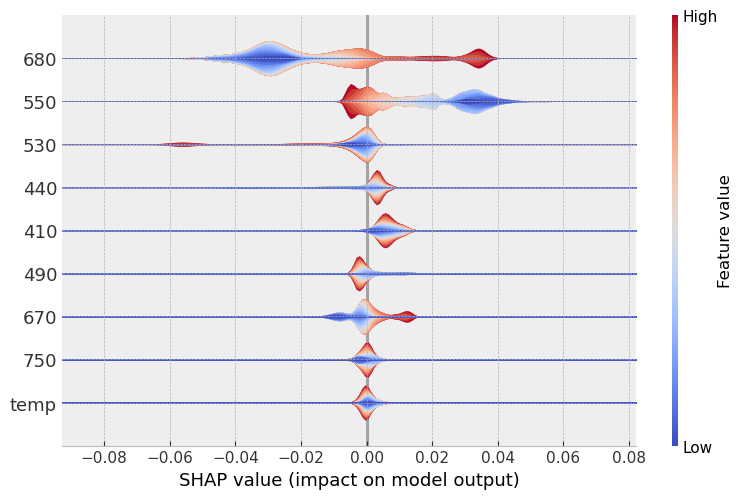

In [ ]:
plot_shap(shap_vasl_modis_dino, X=X, 
          target_name='dinoflagellate', input_types='full_verification')

In [131]:
Xs = dX_modis_test.sample(20000)
for k, v in model_nums.items():
    compute_and_plot_shaps(
        target=k, optimized_model=modis_optimized_model, model_num=v, 
        X=Xs, sensor='MODIS', show_n_features=9,
        xlabel='', title=full_names[k])

2025-04-02 15:29:53.521 | INFO     | __main__:compute_and_plot_shaps:11 - Saved figure as shap_MODIS_dia.png
2025-04-02 15:29:56.192 | INFO     | __main__:compute_and_plot_shaps:11 - Saved figure as shap_MODIS_chl.png
2025-04-02 15:29:58.674 | INFO     | __main__:compute_and_plot_shaps:11 - Saved figure as shap_MODIS_cya.png
2025-04-02 15:30:01.178 | INFO     | __main__:compute_and_plot_shaps:11 - Saved figure as shap_MODIS_coc.png
2025-04-02 15:30:03.655 | INFO     | __main__:compute_and_plot_shaps:11 - Saved figure as shap_MODIS_din.png
2025-04-02 15:30:06.094 | INFO     | __main__:compute_and_plot_shaps:11 - Saved figure as shap_MODIS_pha.png
2025-04-02 15:30:08.938 | INFO     | __main__:compute_and_plot_shaps:11 - Saved figure as shap_MODIS_tot_cphyl.png


<Figure size 800x510 with 0 Axes>

#### VIIRS

In [125]:
model = viirs_optimized_model.estimators_[4]
X = dX_viirs_test.sample(20000)
shap_vasl_viirs_dino = compute_shapley_values(model=model, X=X)

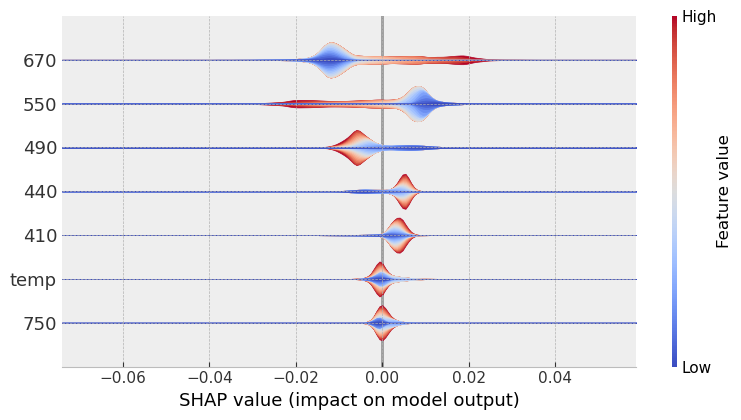

In [126]:
plot_shap(shap_vasl_viirs_dino, X=X, 
          target_name='dinoflagellate', input_types='full_verification')

In [132]:
Xs = dX_viirs_test.sample(20000)
for k, v in model_nums.items():
    compute_and_plot_shaps(
        target=k, optimized_model=viirs_optimized_model, model_num=v, 
        X=Xs, sensor='VIIRS', show_n_features=7,
        xlabel='', title=full_names[k])

2025-04-02 15:32:26.693 | INFO     | __main__:compute_and_plot_shaps:11 - Saved figure as shap_VIIRS_dia.png
2025-04-02 15:34:47.922 | INFO     | __main__:compute_and_plot_shaps:11 - Saved figure as shap_VIIRS_chl.png
2025-04-02 15:36:43.461 | INFO     | __main__:compute_and_plot_shaps:11 - Saved figure as shap_VIIRS_cya.png
2025-04-02 15:39:12.110 | INFO     | __main__:compute_and_plot_shaps:11 - Saved figure as shap_VIIRS_coc.png
2025-04-02 15:40:30.427 | INFO     | __main__:compute_and_plot_shaps:11 - Saved figure as shap_VIIRS_din.png
2025-04-02 15:42:21.750 | INFO     | __main__:compute_and_plot_shaps:11 - Saved figure as shap_VIIRS_pha.png
2025-04-02 15:44:18.686 | INFO     | __main__:compute_and_plot_shaps:11 - Saved figure as shap_VIIRS_tot_cphyl.png


<Figure size 800x430 with 0 Axes>

In [129]:
joblib.dump(modis_optimized_model,project_path / "models/modis_optimized_trained_model.pkl")
logger.info("MODIS Model saved successfully.")

2025-04-02 15:25:29.241 | INFO     | __main__:<module>:2 - MODIS Model saved successfully.


In [130]:
joblib.dump(viirs_optimized_model, project_path / "models/viirs_optimized_trained_model.pkl")
logger.info("VIIRS Model saved successfully.")

2025-04-02 15:26:03.587 | INFO     | __main__:<module>:2 - VIIRS Model saved successfully.
